# Using the NCMATComposer to create new materials.

This notebook describes how one can use the NCMATComposer helper class from the NCrystal Python modules to create [NCMAT data](https://github.com/mctools/ncrystal/wiki/NCMAT-format) representing a given material to be used with NCrystal. This can either be done by directly inputting all desired material data directly, or by (fully or partially) using data from existing sources: NCMAT data, NCrystal.Info objects, NCrystal cfg-strings, CIF files, chemical formulas, Quantum Espresso output, and many other files through [ASE](https://wiki.fysik.dtu.dk/ase/). Rather than being a complete API reference, the present page will simply present a range of examples.

## Preamble
Install dependencies and prepare plots. Feel free to edit as you wish:

In [1]:
#By default we only do pip installs on Google Colab, but you
#can set the variable in the next line to True if you need it:
always_do_pip_installs = False
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if always_do_pip_installs or google_colab:
    from importlib.util import find_spec as _fs
    if not _fs('NCrystal'):
        %pip -q install ncrystal ipympl numpy matplotlib spglib
#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
%matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  3009006, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


## Basic usage ##
For the most basic examples, we will keep things simple and look at how to construct both a simple gaseous material and a very simple crystalline material. We will in all cases use the `NCMATComposer` class from the NCrystal Python API to do this, although we could have also just written [NCMAT](https://github.com/mctools/ncrystal/wiki/NCMAT-format) text data directly, if we would have preferred this.

### A simple gaseous material
To start with, we can define a material described as a free gas of non-interacting atoms. For gasses, composing it like  We do this by creating an empty `NCMATComposer` instance, and then filling in dynamic information ("dyninfo") as appropriate:

*Small note: if you actually need gas mixtures in your simulations, you most likely do not want to create them using the NCMATComposer interface, since there is an alternative which is a lot easier and has more features: Simply use a special cfg-string like `"gasmix::0.7xCO2+0.3xAr/2bar/0.001relhumidity"` (more details on https://github.com/mctools/ncrystal/wiki/Announcement-Release3.2.0).*

In [2]:
c_gas = NC.NCMATComposer()
c_gas.set_dyninfo_freegas( 'He', fraction = 0.91 )
c_gas.set_dyninfo_freegas( 'Ne', fraction = 0.09 )
c_gas.set_state_of_matter( 'gas' )#to be expressive, this line not strictly needed
c_gas.set_density(0.233642,'kg/m3')

Note that the entire NCrystal Python API includes documentation, so you can always do:

In [3]:
# help( c_gas ) or help (NC.NCMATComposer) to show all methods of the NCMATComposer
help(c_gas.set_density) #<--- get info about a particular method

Help on method set_density in module NCrystal.ncmat:

set_density(value, unit='g/cm3') method of NCrystal.ncmat.NCMATComposer instance
    Specify material density for non-crystalline materials. If provided,
    the unit must be a string which is one of "g/cm3" (default) , "kg/m3",
    or "atoms/Aa3". Note that any material can have its density modified
    with the cfg-string parameter "density", while the present method is
    instead used to provide the basic density embedded in NCMAT format for
    non-crystalline materials.



Now, let us see what the material we have defined in our NCMATComposer instance looks like. First let us inspect the resulting NCMAT data directly:

In [4]:
print( c_gas.create_ncmat() )

NCMAT v7
# Autogenerated by NCMATComposer
#
# He91Ne9
#
@DENSITY
  0.233642 kg_per_m3
@STATEOFMATTER
  gas
@DYNINFO
  element He
  fraction .91
  type freegas
@DYNINFO
  element Ne
  fraction .09
  type freegas



That seems OK (although for such a simple material it would not have been hard to hand-write the NCMAT data!). For reference it should be noted that the reference documentation of the NCMAT format can be found at https://github.com/mctools/ncrystal/wiki/NCMAT-format

Instead of merely inspecting the NCMAT data, we can try to see how the material looks after being loaded with NCrystal:

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: <anonymous-ncmat-data>
----------------------------------------------------------------------------------------------------
Density : 0.000233642 g/cm3, 2.57767e-05 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 91% He 9% Ne
----------------------------------------------------------------------------------------------------
Composition (by mass): 66.7281% He 33.2719% Ne
----------------------------------------------------------------------------------------------------
Atom data:
   He = He(cohSL=3.26548fm cohXS=1.34barn incXS=0barn absXS=0.00747barn mass=4.0026u Z=2)
   Ne = Ne(cohSL=4.56

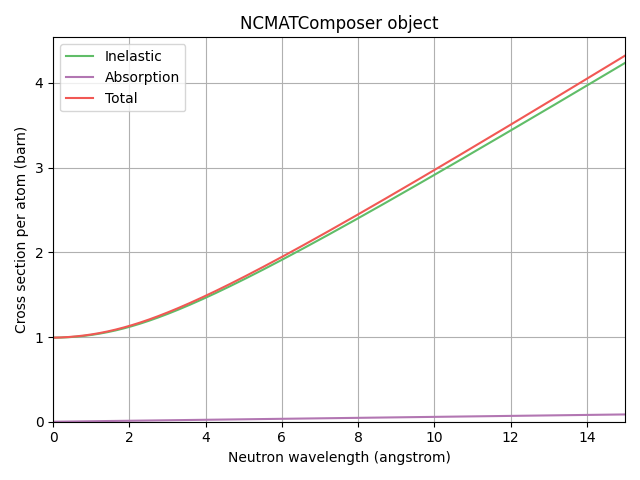

In [5]:
c_gas.inspect() #use c_gas.plot_xsect() instead to avoid printouts and only see the plot

Now, assuming we are happy with the material, we can store it so it can be used in simulations. We can for instance do:

In [6]:
c_gas.write('mysillygas.ncmat')

PosixPath('mysillygas.ncmat')

We can verify that the file was indeed written:

In [7]:
import pathlib
print(pathlib.Path('mysillygas.ncmat').read_text())

NCMAT v7
# Autogenerated by NCMATComposer
#
# He91Ne9
#
@DENSITY
  0.233642 kg_per_m3
@STATEOFMATTER
  gas
@DYNINFO
  element He
  fraction .91
  type freegas
@DYNINFO
  element Ne
  fraction .09
  type freegas



And we can use it in NCrystal cfg-strings as usual (notice that just for fun we change the temperature when loading the material - refer to https://github.com/mctools/ncrystal/wiki/CfgRefDoc for details about the available cfg parameters):

In [8]:
scatter = NC.createScatter("mysillygas.ncmat;temp=50K")
scatter.dump()

ProcComposition(2 components, isotropic)
   |-- 0.91 * FreeGas(sigma_free=0.854857barn;T=50K;M=4.0026u)
   \-- 0.09 * FreeGas(sigma_free=2.38364barn;T=50K;M=20.1794u)


If you don't need a physical file, but only need the material for usage in the current process, you can simply register the file with a virtual name in memory instead:

In [9]:
c_gas.register_as('mysillygas2.ncmat')

'mysillygas2.ncmat'

This created no actual file on the system, but NCrystal keeps it as a virtual file in memory:

In [10]:
scatter = NC.createScatter("mysillygas2.ncmat;temp=50K")
scatter.dump()

ProcComposition(2 components, isotropic)
   |-- 0.91 * FreeGas(sigma_free=0.854857barn;T=50K;M=4.0026u)
   \-- 0.09 * FreeGas(sigma_free=2.38364barn;T=50K;M=20.1794u)


*Small note: if you actually need gas mixtures in your simulations, you most likely do not want to create them using the NCMATComposer interface, since there is an alternative which is a lot easier and has more features: Simply use a special cfg-string like `"gasmix::0.7xCO2+0.3xAr/2bar/0.001relhumidity"` (more details on https://github.com/mctools/ncrystal/wiki/Announcement-Release3.2.0).*

### A simple crystalline material
Let us proceed to add a slightly more advanced material, one with a crystal structure. Albeit a simple one, that we can add by hand. We will add FCC aluminium, in which Al atoms sits on the face-centers and corners of a cubic unit cell of edge length 4.05Å:

In [11]:
c_Al = NC.NCMATComposer()
c_Al.set_cellsg_cubic( 4.05 )#here we could also have provided spacegroup=225, but we will autodetect it instead below
c_Al.set_atompos( [ ('Al',0,0,0),
                    ('Al',0,1/2,1/2),
                    ('Al',1/2,0,1/2),
                    ('Al',1/2,1/2,0)])

This fixes the structure, and therefore also density and composition of the material. However, we are missing the material dynamics, which is a prerequisite for modelling any kind of scattering. As a quick workaround we can simply indicate that we are OK by using an idealised quadratic phonon spectrum for a Debye temperature of 300K:

In [12]:
c_Al.allow_fallback_dyninfo()

In principle the material is now OK, however as a precaution against creating NCMAT data files with misleading or incorrect crystal structure, NCrystal will by default always use `spglib` ("space group library") to try to verify that the structure matches the provided spacegroup. Since we did *not* provide a spacegroup, this will fail:

In [13]:
try:
    c_Al.create_ncmat()
except RuntimeError as e:
    print('FAILED:',e)

FAILED: Must provide a space group number (or invoke .refine_crystal_structure()) before it is possible to verify a crystal structure


To continue, we can use `spglib` to determine the spacegroup from the symmetries given by our unit cell and atom positions:

In [14]:
c_Al.refine_crystal_structure()

Self-consistency of structure was verified by spglib


And now the material has been updated to include the spacegroup (which should be 225 for aluminium):

In [15]:
print( c_Al() )

NCMAT v7
# Autogenerated by NCMATComposer
#
# Al (cubic, SG-225)
#
# Atoms per unit cell: 4xAl
#
# WARNING: Fallback (dummy) Debye temperature value was used for 1 atom!
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  cubic 4.05
@SPACEGROUP
  225
@ATOMPOSITIONS
  Al 0 0 0
  Al 0 1/2 1/2
  Al 1/2 0 1/2
  Al 1/2 1/2 0
@DYNINFO
  # WARNING: Using fallback Debye temperature value!
  element Al
  fraction 1
  type vdosdebye
  debye_temp 300



Hurray, indeed the spacegroup was detected as 225 as it should! For fun, you can go up and edit the atom positions in the `set_atompos(..)` call by changing the `'Al'` at `0,0,0` to `'Cr'`, run the cells again, and see how the detected spacegroup changes to 221: you broke some symmetries by having one of the atoms being of a different type, so the spacegroup changed.

Clearly the approach of manually adding atom positions is too cumbersome and error-prone for more complicated crystal structures, so we will see in the next Notebook how one can extract them from structures in existing files (esp. CIF files) and databases. For these cases, the crystal structure verification which was a bit annoying for our simple hand-written crystal, becomes very important since not all crystal definitions out there *in the wild* are entirely self consistent.

Finally, it should be mentioned that if you have knowledge of atomic displacements, Debye temperatures, or (best) phonon VDOS curves for the atoms in the material, you should absolutely add them as well with some sort of call like `c.set_dyninfo_xxx('Al',...)`. Refer to the next section, for more details about how to do that. The only thing to mention here, is that the `c.set_dyninfo_xxx('Al',...)` calls do not have to include a `fraction=...` parameter for crystalline materials, since the fractions can be inferred from the list of atomic positions.

We can of course again *inspect* the material we just composed:

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: <anonymous-ncmat-data>
----------------------------------------------------------------------------------------------------
Density : 2.69781 g/cm3, 0.0602136 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 100% Al
----------------------------------------------------------------------------------------------------
Composition (by mass): 100% Al
----------------------------------------------------------------------------------------------------
Atom data:
   Al = Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815u Z=13)
------------------------------------------

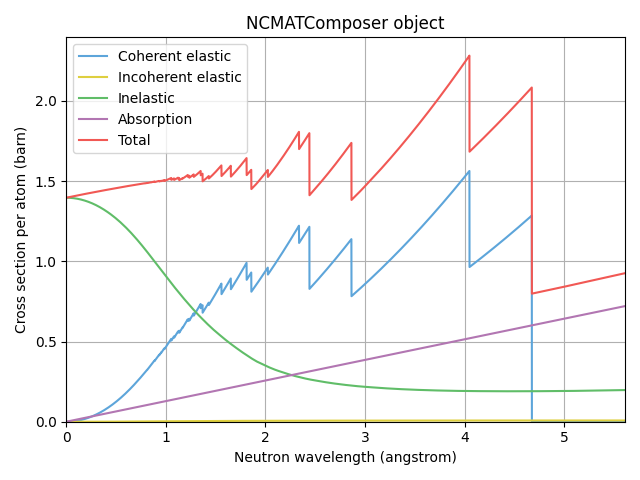

In [16]:
c_Al.inspect()

## Specifying dynamic information
Whether or not a material is crystalline, the dynamics of the contained atoms always has a direct connection to all modes of scattering of thermal neutrons on the material. We already saw above how one can mark the dynamics of a particular constituent to be modelled with a free gas model, using `c.set_dyninfo_freegas(...)`. Such a free-gas model is not in general appropriate for a description of a solid, where the atoms are after all bound rather than free. For completeness, NCrystal currently (v3.6) supports the following forms of dynamics information:

* **Free gas**: Model atoms according to a free-gas model. This is mainly intended for gasses and as a fall-back solution for less important components in liquids (e.g. O in H2O, since neutron scattering is dominated by scattering on H).
* **Scattering kernel**: Tabulated S(α,β) function (same as S(q,ω)), suitable for inelastic scattering in liquids. Such a kernel is only valid at a particular temperature.
* **Phonon DOS (VDOS) curve**, describing the frequency spectrum of oscillations of a particular component. This is by NCrystal both in order to create a scattering-kernel for modelling of inelastic scattering, and for determining the Debye-Waller factors needed for modelling of elastic scattering.
* **A Debye temperature**. This is used by NCrystal to create an idealised Phonon DOS curve, which is then used as in the previous item.
* **A mean-square-displacement (a.k.a. "Uiso")** of atoms at a given temperature. This is converted into a Debye temperature by the NCMATComposer.
* For completeness (for debugging purposes only!): There is also a "sterile" model, which can be used in gasses or liquids to remove the contribution to neutron scattering by a given material component.

### Example amorphous solid
As an example, here is how to setup an amorphous solid, in the form of a very crude model of polyethylene, "PE") where all we know is the material composition, density, and mean-squared atomic displacements at a given temperature (here 50K):

In [17]:
c_PE = NC.NCMATComposer()
help(c_PE.set_dyninfo_msd)

Help on method set_dyninfo_msd in module NCrystal.ncmat:

set_dyninfo_msd(label, msd, *, temperature, fraction=None, comment=None) method of NCrystal.ncmat.NCMATComposer instance
    Calculate and set Debye temperature based on
    mean-squared-displacement (msd) value (in Aa^2). This also needs the
    temperature value for which the msd value is associated (in
    kelvin). Note that this temperature value is NOT necessarily the
    temperature at which the material will later be used. See
    .set_dyninfo_vdosdebye(..) for further information about the resulting
    modelling.



In [18]:
c_PE.set_dyninfo_msd('H',msd=0.022,temperature=50,fraction=2/3)
c_PE.set_dyninfo_msd('C',msd=0.0076,temperature=50,fraction=1/3)
c_PE.set_density(0.92,'g/cm3')
print(c_PE.create_ncmat())

NCMAT v7
# Autogenerated by NCMATComposer
#
# CH2
#
@DENSITY
  0.92 g_per_cm3
@DYNINFO
  # Debye temperature value derived from msd=0.0076Aa^2 @ T=50K (mass=12.011u)
  element C
  fraction 1/3
  type vdosdebye
  debye_temp 433.418
@DYNINFO
  # Debye temperature value derived from msd=0.022Aa^2 @ T=50K (mass=1.00798u)
  element H
  fraction 2/3
  type vdosdebye
  debye_temp 1650.53



We will return to a discussion of atomic displacements and Debye temperatures shortly, but first let us check our material:

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: <anonymous-ncmat-data>
----------------------------------------------------------------------------------------------------
Density : 0.92 g/cm3, 0.118494 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 66.6667% H 33.3333% C
----------------------------------------------------------------------------------------------------
Composition (by mass): 14.372% H 85.628% C
----------------------------------------------------------------------------------------------------
Atom data:
   H = H(cohSL=-3.739fm cohXS=1.75679barn incXS=80.26barn absXS=0.3326barn mass=1.00798u Z=1)
   C = C(cohSL=6.646fm

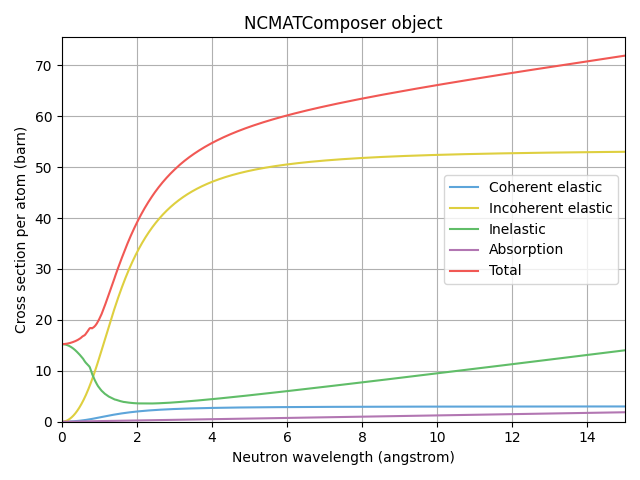

In [19]:
c_PE.inspect()

#### Interlude: Debye model (debye_temp, atomic displacements, and idealised DOS curves)
You can use the following widget to investigate the relationship between Debye temperature and atomic displacements, and even to see the corresponding simplistic phonon DOS curve. Note that the numerical model used to correlate atomic displacements and Debye temperature is discussed in section 2.5 of the original NCrystal paper (https://doi.org/10.1016/j.cpc.2019.07.015).

In [20]:
from ipywidgets import interact
@interact(debye_temp=(50.0,2000.0),atom_mass=(1.008,250.0),temperature=(1.0,2000),show_dos=['hide','unit THz','unit 1/cm','unit meV'])
def show_msd(debye_temp = 300,atom_mass=12.0,temperature=300.0,show_dos='hide'):
    import numpy as np
    msd=NC.debyeIsotropicMSD(debye_temperature=debye_temp,mass=atom_mass,temperature=temperature)
    print(f'\nDisplacement (δ² a.k.a. Uiso a.k.a. "msd" ): {msd:g}Å² = ({np.sqrt(msd):g}Å)²')
    print(f'Debye energy (k_boltzmann*debye_temp)      : {NC.constant_boltzmann*debye_temp*1000.0} meV\n')
    if show_dos.startswith('unit '):
        import NCrystal.plot as ncplot
        ncplot.plot_vdos(debye_temp,labelfct=lambda x : f'TDebye={debye_temp}K',unit=show_dos[5:])

interactive(children=(FloatSlider(value=300.0, description='debye_temp', max=2000.0, min=50.0), FloatSlider(va…

### Direct scattering kernels (mostly for liquids)
It is of course also possible in NCrystal to add externally available scattering kernels to materials. However, there are several complications one needs to be aware of:

1. Such pre-calculated kernels will only be valid for a specific temperature, and attempting to modify the temperature to a different value (i.e. `"mymat.ncmat;temp=200K"`) will result in an error.

2. Such pre-calculated kernels are large. For that reason, we currently (v3.6) only ship two materials in our standard data library, namely room temperature water and heavy water. We do that for the simple reason, that our VDOS expansion code currently only supports solids, and not liquids. For other temperatures, one can find and download data files from the `validated` subfolder at: https://github.com/mctools/ncrystal-extra/tree/master/data . In the same repository, one can also find other materials converted from the ENDF v8 release, however one should most likely be very careful when using these, since they were not manually validated and at the very least lacks proper densities and crystal structures.

3. It is currently not possible for NCrystal to estimate atomic displacements from pre-calculated kernels, so materials with these will only provide inelastic scattering. Again, this is mostly suitable for liquids.

As an example, here is a quick view of the scattering kernel for oxygen in room temperature heavy water (note the need to tune clim/xlim/ylim keywords in order to get a reasonable plot):

NCrystal WARNING: Discarding 120 edges of provided kernel data due to missing S values.


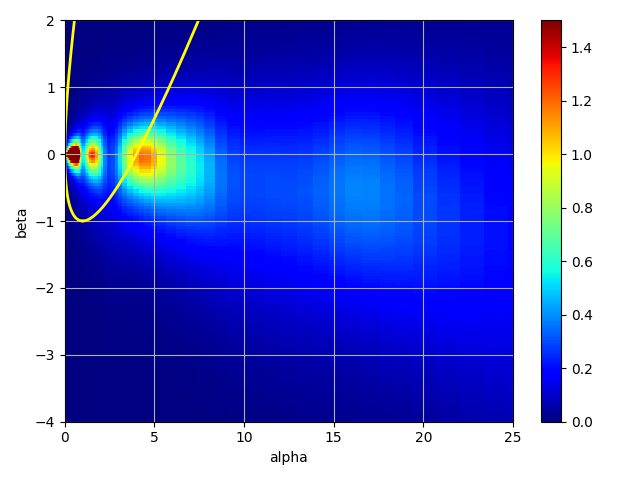

In [21]:
info_D2O = NC.createInfo('LiquidHeavyWaterD2O_T293.6K.ncmat')
di = info_D2O.findDynInfo('O')
di.plot_knl(clim=(0,1.5),xlim=(0,25),ylim=(-4,2),phasespace_curves=[NC.wl2ekin(1.8)])

### Getting atomic displacement from VDOS

When a phonon VDOS curve is available, it is possible to estimate the mean-squared atomic displacements at a given temperature by performing a numerical integral over the DOS curve multiplied by a function $f(E)=\frac{1}{E\tanh(E/2kT)}$. 

Now, $E\tanh(E/2kT)$ tends to 0 like $E^2$, so in order for the integral to be well-formed, it is important that the DOS also tends to 0 like at least $E^2$ near $E=0$. This assumption is always required for phonon curves in NCrystal, and we will go into more details about that in another notebook.

The important point is: A phonon VDOS curve is sufficient to provide not only inelastic scattering physics in solids, but also the Debye-Waller factors needed to model elastic physics. Specifically NCrystal use these Debye-waller factors to model both incoherent-elastic components, as well as coherent-elastic components (incl. Bragg diffraction in case of a crystalline material).

## Comparing our simple Al+PE with more realistic materials:
Now, by not specifying full phonon DOS curves for our simplistic aluminium and polyethylene materials, we are of course loosing a lot of realism. We can compare the resulting inelastic cross section arising from our crude VDOS curves in `c_Al` and `c_PE`, with those from more realistic materials defined in the NCrystal std library:

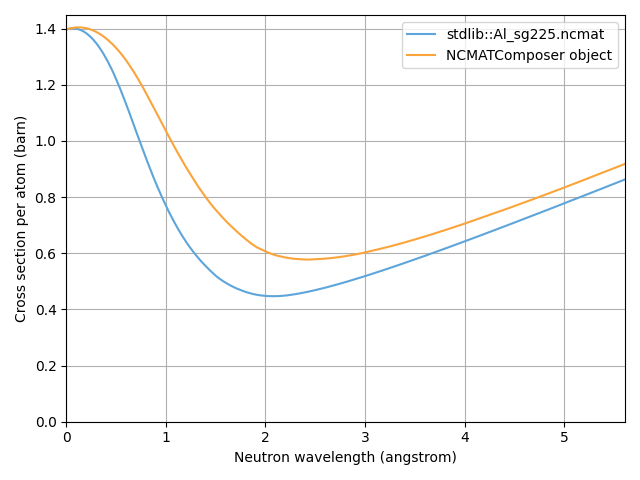

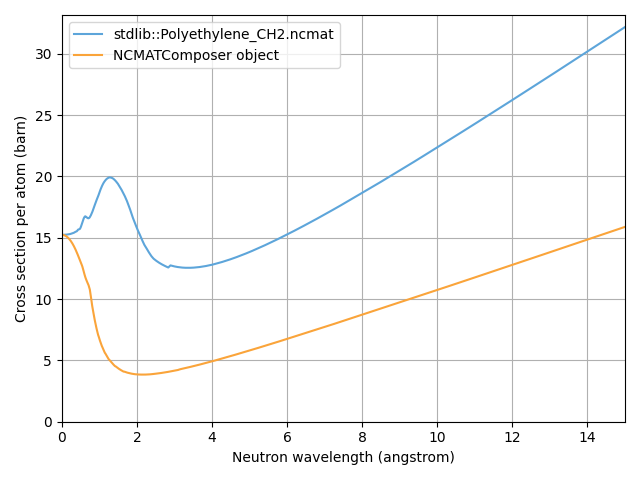

In [22]:
import NCrystal.plot as ncplot
ncplot.plot_xsects('stdlib::Al_sg225.ncmat',c_Al,extra_cfg="comp=inelas")
ncplot.plot_xsects('stdlib::Polyethylene_CH2.ncmat',c_PE,extra_cfg="comp=inelas")

For aluminium the crude VDOS does relatively well, while the same is not the case for polyethylene. We can begin to understand why, if we look at the VDOS curves:

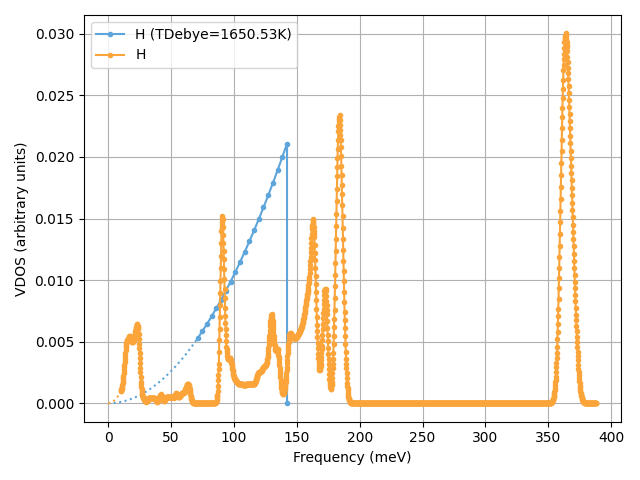

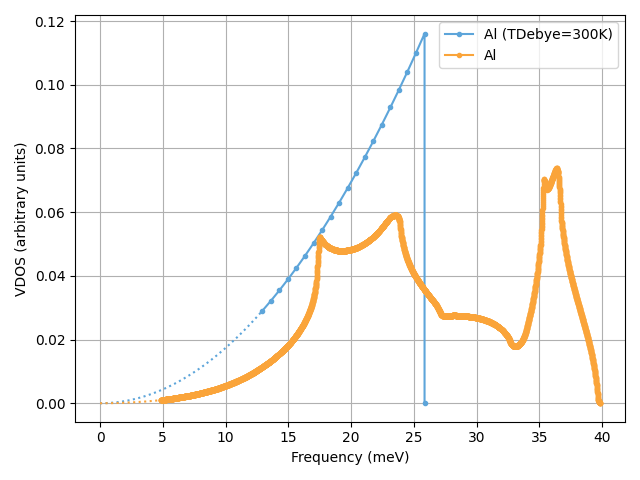

In [23]:
import NCrystal.plot as ncplot
info_stdAl = NC.createInfo('stdlib::Al_sg225.ncmat')
info_stdPE = NC.createInfo('stdlib::Polyethylene_CH2.ncmat')
ncplot.plot_vdos(c_PE.load().info.findDynInfo('H'),info_stdPE.findDynInfo('H'))
ncplot.plot_vdos(c_Al.load().info.findDynInfo('Al'),info_stdAl.findDynInfo('Al'))

Remember that the `TDebye=300K` for Al was simply a hard-coded fallback value (a value around `412K` would have been better). We will return to the connection between VDOS curves, scattering kernels, and neutron cross sections in the next notebook, as well as discussing how to acquire and-process such curves.

## Atom labels and compositions
In all the previous examples, all of the components like `"Al"`, `"C"`, `"H`", etc. we have added to materials in `NCMATComposer`, have been using labels which also happen to be names of elements of the periodic table. For that reason, we did not further need to define the actual atomic compositions of the individual components. However, we certainly can do so when needed. Additionally, in some materials the same element can appear in different roles - for instance imagine a monoatomic crystalline material where not all positions in the crystal unit cell are associated with the same average atomic displacement. In the following, we will show a few examples of this.

First, here is another go at a crude aluminium crystal, this time with a bit of chromium contaminating the structure:

In [24]:
import NCrystal as NC
c_Al2 = NC.NCMATComposer()
c_Al2.set_cellsg_cubic( 4.05, spacegroup=225 )
c_Al2.set_atompos( [('Al',0,0,0),('Al',0,1/2,1/2),('Al',1/2,0,1/2),('Al',1/2,1/2,0)])
c_Al2.allow_fallback_dyninfo()
c_Al2.set_composition('Al','0.99 Al 0.01 Cr')
print(c_Al2())

NCMAT v7
# Autogenerated by NCMATComposer
#
# Al99Cr (cubic, SG-225)
#
# Atoms per unit cell: 3.96xAl+0.04xCr
#
# WARNING: Fallback (dummy) Debye temperature value was used for 1 atom!
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  cubic 4.05
@SPACEGROUP
  225
@ATOMPOSITIONS
  X1 0 0 0
  X1 0 1/2 1/2
  X1 1/2 0 1/2
  X1 1/2 1/2 0
@ATOMDB
  X1 is 0.99 Al 0.01 Cr
@DYNINFO
  # WARNING: Using fallback Debye temperature value!
  element X1
  fraction 1
  type vdosdebye
  debye_temp 300



The format used in the call to `.set_composition` can be very flexible, as described in the help:

In [25]:
help(c_Al2.set_composition)

Help on method set_composition in module NCrystal.ncmat:

set_composition(label, *composition) method of NCrystal.ncmat.NCMATComposer instance
    Use like .set_composition('H','D') or .set_composition('H is D'). Mixtures
    can also be defined, for instance like .set_composition('H','0.2 H1 0.8
    H2'). For a more in-depth discussion of the syntax, consult the @ATOMDB
    section on https://github.com/mctools/ncrystal/wiki/NCMAT-format

    Set atomic composition associated with a given label. Usage examples:

    .set_composition('mylbl','Al') #mylbl now has a composition of only (natural) Al atoms.
    .set_composition('Al','Al') #Al atoms (notice this call is not needed
                                #since the label is already an element name).
    .set_composition('Al','Cr') #Well if you want to use confusing labels you can
    .set_composition('mylbl','Li6') #specific isotope
    .set_composition('mylbl','D') #deuterium is supported by either 'D' or 'H2'

    More complicated

If we call `.set_composition`, it doesn't matter if we used a label like `"Al"` which is an element, or something else (`"atom1"`, `"my_Al"`, ...) -- the `.set_composition` call takes precedence. Here is an material where some aluminium atoms have different atomic displacements (hence the spacegroup is no longer 225):

In [26]:
import NCrystal as NC
c_Al3 = NC.NCMATComposer()
c_Al3.set_cellsg_cubic( 4.05 )
c_Al3.set_atompos( [('tight_atom',0,0,0),('loose_atom',0,1/2,1/2),('loose_atom',1/2,0,1/2),('loose_atom',1/2,1/2,0)])
c_Al3.set_dyninfo_msd('tight_atom',msd=0.005, temperature=200)
c_Al3.set_dyninfo_msd('loose_atom',msd=0.02, temperature=200)
c_Al3.set_composition('tight_atom','Al')
c_Al3.set_composition('loose_atom','Al')
c_Al3.refine_crystal_structure()#Detect spacegroup
print(c_Al3())

Self-consistency of structure was verified by spglib
NCMAT v7
# Autogenerated by NCMATComposer
#
# Al (cubic, SG-221)
#
# Atoms per unit cell: 4xAl
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  cubic 4.05
@SPACEGROUP
  221
@ATOMPOSITIONS
  X1 0 1/2 1/2
  X1 1/2 0 1/2
  X1 1/2 1/2 0
  X2 0 0 0
@ATOMDB
  X1 is Al
  X2 is Al
@DYNINFO
  # Debye temperature value derived from msd=0.02Aa^2 @ T=200K (mass=26.9815u)
  element X1
  fraction 3/4
  type vdosdebye
  debye_temp 236.653
@DYNINFO
  # Debye temperature value derived from msd=0.005Aa^2 @ T=200K (mass=26.9815u)
  element X2
  fraction 1/4
  type vdosdebye
  debye_temp 501.243



## Adding secondary phases (+SANS)
Secondary phases can also be added to a material, and we can even have long-scale diffraction between phases with different scattering length densities, resulting in small-angle-neutron scattering (SANS). Here we are modelling a made-up material consisting of aluminium with small R=50Å void cavities. Note however, that the SANS physics is so far considered a tech-preview with non-finalised NCMAT syntax, so using this material will result in a warning about usage of `@CUSTOM_` sections.


NCMAT v7
# Autogenerated by NCMATComposer
#
# Al (cubic, SG-225)
#
# Atoms per unit cell: 4xAl
#
# NOTICE: crystal structure was verified with spglib to be self-consistent.
#
@CELL
  cubic 4.04958
@SPACEGROUP
  225
@ATOMPOSITIONS
  Al 0 0 0
  Al 0 1/2 1/2
  Al 1/2 0 1/2
  Al 1/2 1/2 0
@OTHERPHASES
  0.01 void.ncmat
@CUSTOM_HARDSPHERESANS
  50.0 #sphere radius in angstrom.
@DYNINFO
  # Transferred from "Al" in existing NCrystal.DynamicInfo object
  element Al
  fraction 1
  type vdos
  vdos_egrid .00485015 .0398222
  vdos_density .013232 .0141193 .0150065 .0158938 .0167811 .0176684 .0185557
     .0195536 .020725 .0218964 .0230678 .0242392 .0254106 .0265808 .027748
     .0289152 .0300825 .0312497 .032417 .0338129 .0352559 .0366988 .0381418
     .0395847 .0412955 .043043 .0447906 .0465382 .0482858 .0500848 .0519404
     .0537959 .0556515 .057507 .0593626 .0613858 .0638226 .0662593 .0686961
     .0711328 .0735696 .0760063 .0785759 .081366 .0841561 .0869462 .0897363
     .0925265 .0954792 .

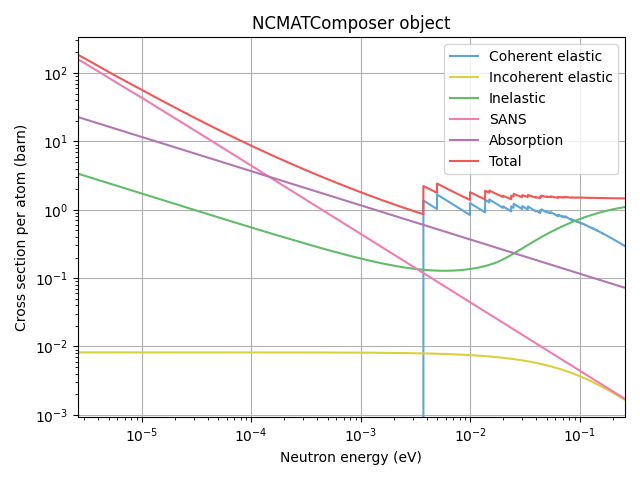

In [27]:
c=NC.NCMATComposer('Al_sg225.ncmat') #<--- Can init from cfg-string.
c.add_secondary_phase(0.01,'void.ncmat')
c.add_hard_sphere_sans_model(50)
print(c())
c.inspect(mode='ekin')

## Modifying atom data like scattering lengths.
It should for completeness be mentioned that one can also set atomic properties like masses or scattering lengths. In practice, this mostly comes in handy if needing to use an element or isotope for which there is no well established data. The data can be provided using the `.update_atomdb` method:

In [28]:
import NCrystal as NC
c_u = NC.NCMATComposer("solid::U/1gcm3")#note: can also init from a cfg-string!
c_u.set_composition('U','U232')
try:
    print(c_u.load())
except NC.NCBadInput as e:
    print('ERROR:',e)

ERROR: Atom with label "U232" is unknown. If it is a valid isotope which is simply missing in NCrystal's internal database you must define it yourself.


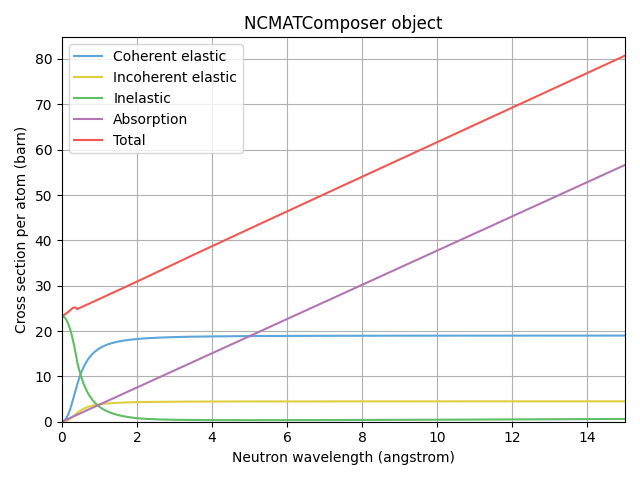

In [29]:
c_u.update_atomdb('U232','232.04u -12.3fm 4.5b 6.789b')#NB: dummy data values!
#alternative syntax: 
c_u.update_atomdb('U232',mass=232.04, coh_scat_len=-12.3, incoh_xs=4.5, abs_xs=6.789)
c_u.plot_xsect()

As mentioned already in another notebook, you can of course also inspect the values in NCrystal's built-in database:

In [30]:
NC.atomDB('B10')#returns AtomData object

B10(cohSL=-0.1fm cohXS=0.00125664barn incXS=3barn absXS=3835barn mass=10.0129amu Z=5 A=10)

And see the entire database:

In [31]:
for e in NC.iterateAtomDB():
    print(e)

H(cohSL=-3.739fm cohXS=1.75679barn incXS=80.26barn absXS=0.3326barn mass=1.00798amu Z=1)
H1(cohSL=-3.7406fm cohXS=1.7583barn incXS=80.27barn absXS=0.3326barn mass=1.00783amu Z=1 A=1)
H2(cohSL=6.671fm cohXS=5.59232barn incXS=2.05barn absXS=0.000519barn mass=2.0141amu Z=1 A=2)
H3(cohSL=4.792fm cohXS=2.88565barn incXS=0.14barn absXS=0barn mass=3.01605amu Z=1 A=3)
He(cohSL=3.26548fm cohXS=1.34barn incXS=0barn absXS=0.00747barn mass=4.0026amu Z=2)
He3(cohSL=5.74fm cohXS=4.14032barn incXS=1.6barn absXS=5333barn mass=3.01603amu Z=2 A=3)
He4(cohSL=3.26fm cohXS=1.3355barn incXS=0barn absXS=0barn mass=4.0026amu Z=2 A=4)
Li(cohSL=-1.9fm cohXS=0.453646barn incXS=0.92barn absXS=70.5barn mass=6.94094amu Z=3)
Li6(cohSL=2fm cohXS=0.502655barn incXS=0.46barn absXS=940barn mass=6.01512amu Z=3 A=6)
Li7(cohSL=-2.22fm cohXS=0.619321barn incXS=0.78barn absXS=0.0454barn mass=7.016amu Z=3 A=7)
Be(cohSL=7.79fm cohXS=7.62579barn incXS=0.0018barn absXS=0.0076barn mass=9.01218amu Z=4)
Be9(cohSL=7.79fm cohXS=7.625

## Creating hydrogen-rich amorphous materials

NCrystal provides both commandline and Python API tools for the easy creation of material definitions for any hydrogen-rich amorphous material (see more at https://github.com/mctools/ncrystal/wiki/Announcement-Release2.7.0#tool-for-easy-creation-of-ncmat-files-for-hydrogen-rich-amorphous-materials). The tool is based on a phonon density curve analysis done in:

> ["Thermal neutron cross sections of amino acids from average contributions of functional groups", G. Romanelli, et. al., J. Phys.: Condens. Matter, (2021). doi:10.1088/1361-648X/abfc13](https://doi.org/10.1088/1361-648X/abfc13)

The point is that since incoherent scattering on hydrogen dominates the scattering in these materials, it is enough to know the hydrogen phonon density curve in order to model them. Additionally the paper above analyses and extracts the contribution from different chemical bindings (functional groups) of hydrogen to the phonon density. Thus, by merely letting NCrystal know to which functional groups hydrogen atoms are bound in the material, NCrystal is able to immediately construct a realistic phonon density for hydrogen. Additionally, the material's density and complete chemical composition must of course also be known, and the dynamics of the other atoms will simply be provided by a Debye model.

So for instance if you wish to create a file for polystyrene you must read the command `--help` text and try to figure out how the hydrogen atoms are bound in the structure:
<div>
<img src="https://raw.githubusercontent.com/wiki/mctools/ncrystal/Announcement-Release2.7.0/Announcement-Release2.7.0_hfg2ncmat.png" width="500"/>
</div>



In [32]:
!ncrystal_hfg2ncmat --help

usage: ncrystal_hfg2ncmat [-h] [--output OUTPUT] [--force] --spec SPEC
                          --formula FORMULA --density DENSITY
                          [--debyetemp VALUE] --title TITLE [--notrim]

Script which can be used to generate NCMAT files for hydrogen-rich amorphous
materials, in which the hydrogen atoms are bound to certain standard functional
groups (e.g. carbohydrates, polyimides, polymers, ...). Based on the material's
density, (empirical) chemical formula, and the specification of hydrogen
bindings in terms of standard functional groups, an NCMAT file is generated. In
this NCMAT file, non-hydrogen atoms are treated with a simplistic model
(idealised Debye model of phonon vibrations, assuming a Debye temperature of
400.0K for all atoms unless --debyetemp is specified), and the hydrogen atoms
are treated with a proper phonon density of state (VDOS) curve, which is
constructed based on the provided binding specifications. This is done using an
idea (and VDOS curves fro

Since NCrystal v3.9.5, it is also possible to access this functionality directly in the Python API. Either via the free-standing function `hfg2ncmat` from the `NCrystal.hfg2ncmat` module, or through its integration with `NCMATComposer` objects, which we will use here. So let us set up an `NCMATComposer` object based on the polystyrene formula above:

In [33]:
c_polystyrene = NC.NCMATComposer.from_hfg(spec='5xCHaro+1xCHali+1xCH2',
                                          formula='C8H8',
                                          title='Polystyrene',
                                          density=0.99)


Generated NCMAT data...
Verifying that it can be loaded with NCrystal...
Succesfully loaded...
Contribution breakdown based on composition:
  Contribution to bound scattering XS from H (incoherent) is 91.65 %
  Contribution to bound scattering XS from C (coherent)   is  6.34 %
  Contribution to bound scattering XS from H (coherent)   is  2.01 %
  Contribution to bound scattering XS from C (incoherent) is  0.00 %


As a sanity check, the printouts above let us know that 91.65% of the scattering in the material comes from incoherent scattering on hydrogen. So at worst, the errors in the description of our material should be about 8% - but likely that is much conservative, given that we do still include some modelling of the other effects in the material. Anyway, let us see the hydrogen phonon DOS that came out of this:

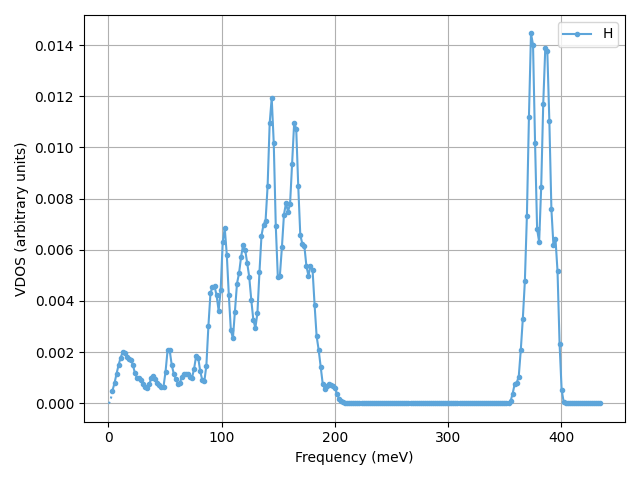

In [34]:
c_polystyrene.load().info.findDynInfo('H').plot_vdos()

And the cross sections from the material:

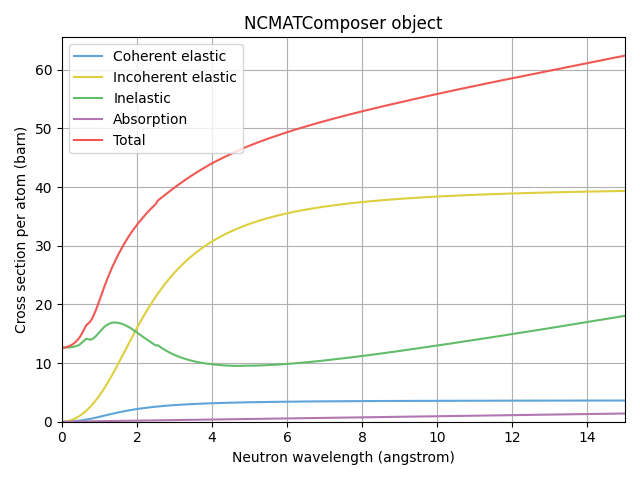

In [35]:
c_polystyrene.plot_xsect()

For fun, we can also construct polyethylene, and try to compare with the two materials from the NCrystal data library:

In [36]:
c_simple_PE = NC.NCMATComposer.from_hfg(spec='1xCH2',
                                        formula='CH2',
                                        title='Polyethylene from HFG',
                                        density=0.96)

Generated NCMAT data...
Verifying that it can be loaded with NCrystal...
Succesfully loaded...
Contribution breakdown based on composition:
  Contribution to bound scattering XS from H (incoherent) is 94.65 %
  Contribution to bound scattering XS from C (coherent)   is  3.27 %
  Contribution to bound scattering XS from H (coherent)   is  2.07 %
  Contribution to bound scattering XS from C (incoherent) is  0.00 %


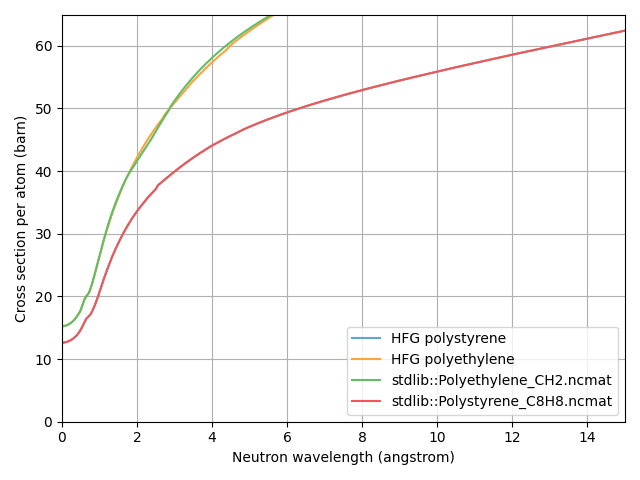

In [37]:
import NCrystal.plot as ncplot
c_polystyrene.set_plotlabel('HFG polystyrene')
c_simple_PE.set_plotlabel('HFG polyethylene')
ncplot.plot_xsects(c_polystyrene,
                   c_simple_PE,
                   'stdlib::Polyethylene_CH2.ncmat',
                   'stdlib::Polystyrene_C8H8.ncmat')

Both materials match up. For the case of Polystyrene, this is trivial since the `stdlib::Polystyrene_C8H8.ncmat` file was actually constructed based on these tools. For the case of Polyethylene, the phonon DOS curve in `stdlib::Polyethylene_CH2.ncmat` actually came from a dedicated study of polyethylene (and includes a dedicated DOS curve for the carbon atoms as well). So the fact that those two curves match pretty well is actually a good indication that the method is sound! For reference, we can check the references for `stdlib::Polyethylene_CH2.ncmat` by looking in the NCMAT data itself:

In [38]:
print(NC.createTextData('stdlib::Polyethylene_CH2.ncmat').rawData)

NCMAT v5
#
# Polyethylene (PE).
#
# Note: This file models amorphous polyethylene, and the density value has been
# set as 0.92, but could vary up to 5% in a given material.
#
# The VDOS curves were calculated using VASP DFT[1], with Phonopy[2] and
# OCLIMAX[3] software by Kemal Ramic from ESS Spallation Physics group.  The
# calculation used an orthorombic unit cell with space group Pnma (62) (specific
# PE structure taken from [4]). and the calculation was done on 3x5x9 k-point
# grid.
#
# The performance was validated against measurements (Granada-1987 and
# Lee-2020), and as an added sanity check it was verified that results were
# consistent with a Polyethylene NCMAT file created with the ncrystal_hfg2ncmat
# command (i.e. the hydrogen VDOS was consistent with one derived via the method
# of G. Romanelli et. al (2021), doi:10.1088/1361-648X/abfc13).
#
# References:
#  [1]: G. Kresse and J. Furthm"uller, Phys. Rev. B 54 , 11 169 (1996.)
#  [2]: "First principles phonon calculations